In [1]:
# using Plots
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random 
using ArraysOfArrays
using ValueShapes
using Measurements
using BAT 

using MultivariateStats
using Clustering

using PyPlot

# 1. Densities

Activate the desired distribution:  

## 1.1 Multivariate Normal Distribution:

In [ ]:
# no correltions: 

n_dims = 3
σ = 1
distribution = MvNormal(n_dims,σ)

prior = NamedTupleDist(
    x = repeat([-5.0 .. 5.0], n_dims),
);

In [439]:
Σ = [3.426818298733095 12.378238116671048 -9.632531611142456; 
    12.378238116671048 69.83909693165143 -43.478993858310886; 
    -9.632531611142456 -43.478993858310886 60.0626256206892]

μ = [8.959570984309234, -9.021529871694005, -5.007789383392622]

n_dims = 3 

distribution = MvNormal(μ, Σ)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

## 1.2 Gaussian Mixture Model (3D): 

In [ ]:
n_dims = 3 

σ_1 = [3.426818298733095 12.378238116671048 -9.632531611142454; 3.426818298733095 4.916266580684483 -5.029942800849483; 3.426818298733095 -6.737309268887753 5.4343957706004415; 3.426818298733095 -3.9729587574454333 3.379361860370276]
σ_2 = [12.378238116671048 69.83909693165143 -43.478993858310886; 4.916266580684482 69.83909693165143 -64.18784570966332; -6.737309268887753 69.83909693165143 32.734776615550174; -3.972958757445433 69.83909693165143 53.74871853095418]
σ_3 = [-9.632531611142456 -43.478993858310886 60.0626256206892; -5.029942800849484 -64.18784570966332 60.0626256206892; 5.4343957706004415 32.734776615550174 60.0626256206892; 3.3793618603702757 53.74871853095418 60.0626256206892]
σ = cat(σ_1,σ_2,σ_3, dims=3)

μ = [8.959570984309234 -9.021529871694005 -5.007789383392622; -1.446445514344754 -7.8327010768703875 -3.2653263028963986; -6.40954093270941 0.25815094665222027 5.830143596540282; 5.076504517881521 -0.8952973253675331 9.16356325348496]

distribution = MixtureModel(MvNormal[MvNormal(μ[i,:], Matrix(Hermitian(σ[i,:,:])) ) for i in 1:4]);

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

## 1.3 Funnel Distribution: 

In [364]:
n_dims = 2

distribution = BAT.FunnelDistribution(n=n_dims)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

## 1.4 Caushy Distribution: 

In [335]:
n_dims = 2

distribution = BAT.MultimodalCauchy(n=n_dims);

prior = NamedTupleDist(
    x = repeat([-10.0 .. 10.0], n_dims),
);

## 1.5 Gaussian Shell: 

In [334]:
n_dims = 2

distribution = BAT.GaussianShell(n=n_dims, r=10);

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

# 2. Sampling

In [440]:
log_likelihood = let dist = distribution
    params -> begin
        LogDVal(logpdf(dist, params.x))
    end
end

posterior = PosteriorDensity(log_likelihood, prior);

In [441]:
nsamples = 10^5

100000

In [442]:
samples = bat_sample(
    posterior, 
    nsamples, MCMCSampling(sampler = MetropolisHastings(), nchains = 4)
).result; # MCMCSampling(sampler = MetropolisHastings(), nchains = 4)

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC tuning of 4 chains successful after 2 cycle(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/m

In [443]:
i_ahmi = bat_integrate(samples).result

┌ Info: Using integration algorithm AHMIntegration{CholeskyPartialWhitening,GeyerAutocorLen}
│   whitening: CholeskyPartialWhitening CholeskyPartialWhitening()
│   autocorlen: GeyerAutocorLen GeyerAutocorLen()
│   volumetype: Symbol HyperRectangle
│   max_startingIDs: Int64 10000
│   max_startingIDs_fraction: Float64 2.5
│   rect_increase: Float64 0.1
│   warning_minstartingids: Int64 16
│   dotrimming: Bool true
│   uncertainty: Array{Symbol}((1,))
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	50000 / 49999	Parameters:	3
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_me

9.981e-7 ± 7.3e-9

In [369]:
# plot(samples)

# 3. Integration

In [370]:
# Convert MCMC samples in a flat vector: 



## 3.1 Whitening: 

In [371]:
# Unweighted samples: 

# samples_resampled = bat_sample(samples, 10^3).result
# samples_flat = collect(flatview(unshaped.(samples_resampled.v)));

# WT = fit(Whitening, samples_flat)
# samples_whittened = transform(WT, samples_flat)

In [465]:
samples_flat = collect(flatview(unshaped.(samples.v)));
samples_weights = samples.weight;
samples_ll = samples.logd;

In [466]:
function whiten_weighted_samples(smpl, w)
    
    smpl_mean = mean(smpl, dims=2)
    smpl = smpl .-  smpl_mean
    cov_m = cov(smpl, FrequencyWeights(w), 2)
    L = eigvals(cov_m)
    E = eigvecs(cov_m)
    W = E'
    smpl = (W * smpl) ./ sqrt.(L .+ 1e-5);
    
    return (samples = smpl, w = W, μ=smpl_mean, l=L)
end

whiten_weighted_samples (generic function with 1 method)

In [467]:
samples_whittened, w_transform, μ_transform, l_transform = whiten_weighted_samples(samples_flat, samples_weights);

In [468]:
det_ransform = det(w_transform ./ sqrt.(l_transform .+ 1e-5))

0.019627338856915783

In [448]:
# fig, ax = subplots(1,1, figsize=(5,5))

# ax.scatter(samples_whittened[1,:], samples_whittened[2,:], alpha=0.1, label="Whittened")
# ax.scatter(samples_flat[1,:], samples_flat[2,:], alpha=0.1, label="Original")
# ax.legend()

# ax.set_xlabel("Param 1")
# ax.set_ylabel("Param 2")

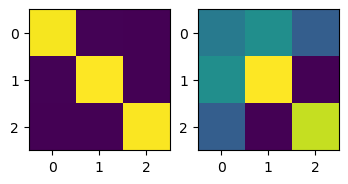

PyObject <matplotlib.image.AxesImage object at 0x7fdfc922c8e0>

In [449]:
fig, ax = subplots(1,2, figsize=(4,8))

ax[1].imshow(cov(samples_whittened'))
ax[2].imshow(cov(samples_flat'))

## 3.2 K-means: 

In [450]:
n_clusters = 20

kmeans_res = kmeans(samples_whittened, n_clusters, weights=samples_weights);
color_list = plt.cm.Spectral(range(0.0, stop=1, length=n_clusters))
colors_kmeans = [color_list[i, :] for i in kmeans_res.assignments];

In [451]:
kmeans_res.centers

3×20 Array{Float64,2}:
 0.055964   1.14818  -0.477863  -0.50537   …   0.514087  -0.981317   0.810728
 1.20722   -1.39485  -0.364213  -1.88183      -0.103901   0.831397   0.956908
 1.08237    0.16339  -1.73882   -0.468594      0.477362  -1.01942   -1.4752

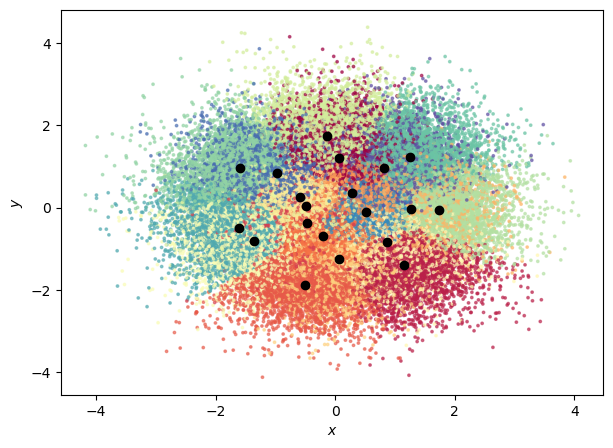

PyObject Text(25.000000000000007, 0.5, '$y$')

In [452]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

sc = ax.scatter(samples_whittened[1,:], samples_whittened[2,:], s=3, alpha=0.6, c=colors_kmeans, cmap="Spectral")

for (j,i) in enumerate(eachcol(kmeans_res.centers))
    ax.scatter(i[1,:], i[2,:], c="k")
end
    
# fig.colorbar(sc)
ax.set_xlabel(L"x")
ax.set_ylabel(L"y")

In [453]:
cluster_number = 17

cluster_mask = kmeans_res.assignments .== cluster_number;

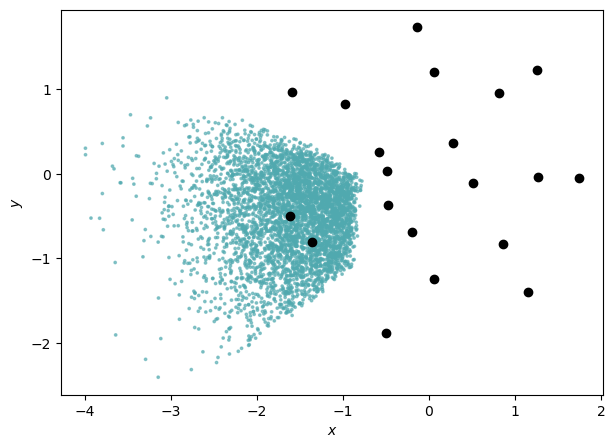

PyObject Text(25.000000000000007, 0.5, '$y$')

In [454]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

sc = ax.scatter(samples_whittened[1,cluster_mask], samples_whittened[2,cluster_mask], s=3, alpha=0.6, c=colors_kmeans[cluster_mask], cmap="Spectral")

for (j,i) in enumerate(eachcol(kmeans_res.centers))
    ax.scatter(i[1,:], i[2,:], c="k")
end
    
# fig.colorbar(sc)
ax.set_xlabel(L"x")
ax.set_ylabel(L"y")

In [455]:
samples_whittened_cl, w_transform_cl, μ_transform_cl, l_transform_cl = whiten_weighted_samples(samples_whittened[:,cluster_mask], samples_weights[cluster_mask]);

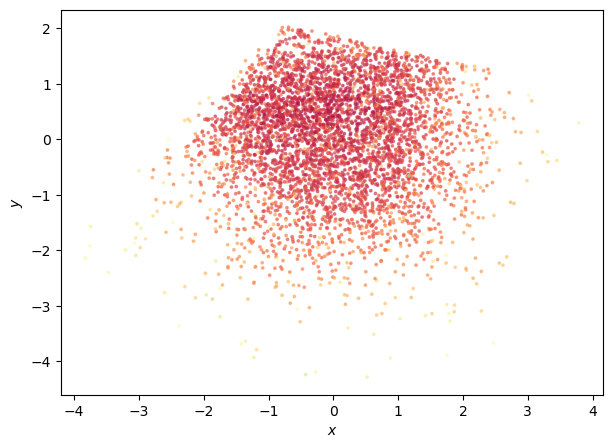

PyObject Text(25.000000000000007, 0.5, '$y$')

In [456]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ll_tmp = (samples_ll .- minimum(samples_ll))
ll_tmp = ll_tmp ./ maximum(ll_tmp)
sc = ax.scatter(samples_whittened_cl[1,:], samples_whittened_cl[2,:], s=3, alpha=0.6, c=plt.cm.Spectral_r(ll_tmp[cluster_mask]))

ax.set_xlabel(L"x")
ax.set_ylabel(L"y")

In [457]:
det_ransform_2 = det(w_transform_cl ./ sqrt.(l_transform_cl .+ 1e-5))

-8.809416320242743

In [458]:
mask = prod(-1 .< samples_whittened_cl .< 1, dims=1 )[1,:]
v = 2^n_dims

8

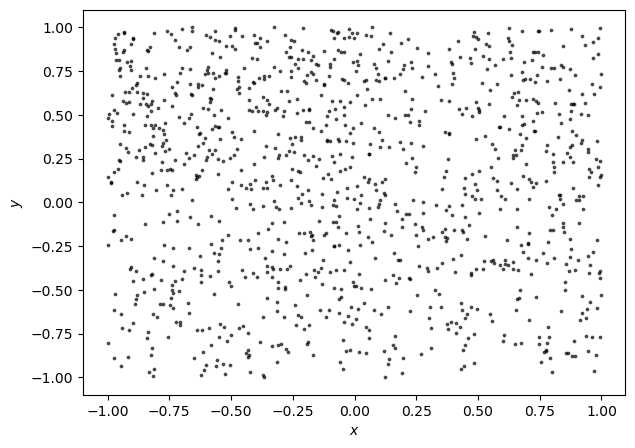

PyObject Text(25.0, 0.5, '$y$')

In [459]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

sc = ax.scatter(samples_whittened_cl[1,mask], samples_whittened_cl[2,mask], s=3, alpha=0.6, c="k")

ax.set_xlabel(L"x")
ax.set_ylabel(L"y")

In [460]:
cluster_mask_double  = deepcopy(cluster_mask)

cluster_mask_double[cluster_mask .== 1] .= mask;

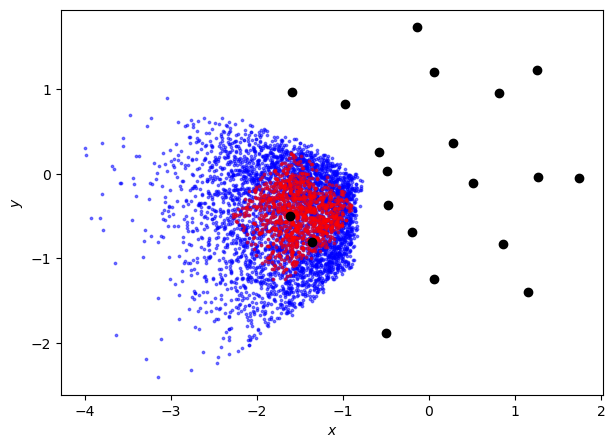

PyObject Text(25.000000000000007, 0.5, '$y$')

In [461]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

sc = ax.scatter(samples_whittened[1,cluster_mask], samples_whittened[2,cluster_mask], s=3, alpha=0.5, c="blue", cmap="Spectral")
sc = ax.scatter(samples_whittened[1,cluster_mask_double], samples_whittened[2,cluster_mask_double], s=3, alpha=0.5, c="red", cmap="Spectral")

# sc = ax.scatter(samples_whittened[1,cluster_mask], samples_whittened[2,cluster_mask], s=3, alpha=0.6, c=colors_kmeans[cluster_mask], cmap="Spectral")

for (j,i) in enumerate(eachcol(kmeans_res.centers))
    ax.scatter(i[1,:], i[2,:], c="k")
end
    
# fig.colorbar(sc)
ax.set_xlabel(L"x")
ax.set_ylabel(L"y")

In [462]:
r = sum(cluster_mask_double .==1 ) / length(cluster_mask_double)

x = mean(1 ./ exp.(samples_ll[cluster_mask_double]), weights(samples_weights[cluster_mask_double]))
i_r = v / (x*det_ransform*det_ransform_2)

I = i_r / r

-9.770672196519332e-7

In [463]:
@show I, i_ahmi

(I, i_ahmi) = (-9.770672196519332e-7, 9.981e-7 ± 7.3e-9)


(-9.770672196519332e-7, 9.981e-7 ± 7.3e-9)

In [464]:
I - i_ahmi

-1.9752e-6 ± 7.3e-9

***

### Algorithm Overview: 

1. Get samples (MCMC samples with frequency weights, resampled samples with unitary weights)
2. Whiten samples
3. Run k-means to cluster points (n clusters depends on problem dmension)
4. Initialize centers of hypervolumes at the center of each cluster 
5. The initial size of s hypervolume is a standard deviation of samples at each cluster.
6. Trim boundaries of clusters to adjust log. likelihood ratio.
7. Compute harmonic mean estimate (HME) for each hypervolume and combine the final estimator. 

### Integration volumes to be considered: 

1. Hyperspheres. 
2. Spherical shells. 